In this notebook, we will show how to compute the GP kernel of a mutilayer perceptron with batchnorm+ReLU.

# Setup

Software prereqs:

- `quadpy`

`quadpy` is a package for fast, vectorized integration, which will be essential for speeding up the computation of the V-transform of batch normalization.

In [1]:
import scipy as sp
from scipy.optimize import root_scalar
import numpy as np
import quadpy as qp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from utils import J1, VReLU

Suppose one has a batch of $B$ samples $x_1, \ldots, x_B \in \mathbb{R}^n$, consider their kernel
$$\Sigma = (x_i^\top x_j / d)_{ij} \in \mathbb{R}^{B \times B}.$$


If $f(x) = \mathrm{ReLU}(W x)$ represents a dense matrix multiplication followed by ReLU, then the matrix $(f(x_i)^\top f(x_j) / n')_{ij}$ converges almost surely to a deterministic positive semidefinite matrix $V_{\mathrm{ReLU}}(\Sigma)$ if $W \in \mathbb{R}^{n' \times n}$ is sampled as $W_{ij} \sim \mathcal{N}(0, 1/n)$ and as $n' \to \infty$.
By [Cho & Saul 2009](http://papers.nips.cc/paper/3628-kernel-methods-for-deep-learning), 
$$V_\mathrm{ReLU}(\Sigma) = D^{1/2} J_1(D^{-1/2} \Sigma D^{-1/2}) D^{1/2}$$
where $D = \mathrm{Diag}(\Sigma)$ and
$$\begin{align*}
    J_1(c)
        &=
            \frac 1 \pi (\sqrt{1 - c^2} + (\pi - \arccos(c))c), \forall c \in [-1, 
            1]
\end{align*}$$

The function `VReLU` applies $V_\mathrm{ReLU}$ to a sequence of matrices represented in the form of a tensor whose last 2 dimensions represent the matrices.

# Mean Field Theory of Batchnorm: Single Batch

Now suppose $f(x_1, \ldots, x_B) = \mathrm{ReLU}(\mathcal{B}(W x_1, \ldots, W x_B)) =: (y_1, \ldots, y_B)$ represents a dense matrix multiplication followed by batchnorm and ReLU.
Then the matrix $(y_i^\top y_j / n')_{ij}$ converges almost surely to a deterministic positive semidefinite matrix
$$V_{\mathcal{B}_\mathrm{ReLU}}(\Sigma)$$
if $W \in \mathbb{R}^{n' \times n}$ is sampled as $W_{ij} \sim \mathcal{N}(0, 1/n)$ and as $n' \to \infty$, just like the above.
According to Theorem 3.2 of [Yang et al. 2019](https://arxiv.org/pdf/1902.08129.pdf), by the Laplace method,
$$\begin{equation}
V_{\mathcal{B}_\mathrm{ReLU}}(\Sigma) = B \int_0^\infty
    \frac{V_\mathrm{ReLU}(\Sigma^G (I + 2s\Sigma^G)^{-1})}
    {\sqrt{\det(I + 2 s \Sigma^G)}} ds
\end{equation}$$
where

$$\begin{align*}
    \Sigma^G &= G \Sigma G\\
    G &= I_B - \frac 1 B \mathbf 1 \mathbf 1^T
\end{align*}$$

In [3]:
def Gmatrix(B):
    return np.eye(B) - np.ones([B, B]) / B

We will compute the integrand of $V_{\mathcal{B}_\mathrm{ReLU}}$ efficiently as follows:

- Obtain eigenvalues of $\Sigma^G$.
$$\Sigma^G = A \Lambda A^\top$$
where $A$ is orthogonal and $\Lambda$ is diagonal.
Note that the smallest eigenvalue of $\Lambda$ is 0, since $\Sigma^G$ has nullity with dimension at least 1.
WLOG, assume the diagonal values of $\Lambda$ are nondecreasing, so that $\Lambda_{11} = 0$.
- Then for each $s$, compute
    - $\Sigma^G(I + 2s \Sigma^G)^{-1} = A \Lambda(I + 2s \Lambda)^{-1} A^\top$.
    - Similarly, $\det(I + 2s\Sigma^G) = \prod_{i=1}^B (1 + 2 s \Lambda_{ii})
        = \prod_{i=2}^B (1 + 2 s \Lambda_{ii})$
    
For each $s$, the most heavy computation will be the two matrix multiplications by $A$ and $A^\top$.

In [4]:
def VBNReLUIntegrand(Sigma):
    '''Returns the integrand function of VBNRelU(Sigma)
    '''
    B = Sigma.shape[0]
    G = Gmatrix(B)
    eigvals, eigvecs = np.linalg.eigh(G @ Sigma @ G)
    def f(s, multfactor=1, eps=1e-10):
        # Ueigvals.shape = [..., B]
        Ueigvals = (1 + 2 * s[..., None] * eigvals)
        # inteigvals.shape = [..., B]
        inteigvals = eigvals / Ueigvals
        # divide by sqrt(det)
        inteigvals /= np.sqrt(np.prod(Ueigvals, axis=-1, keepdims=True))
        # the eigenspace corresponding to (1, ..., 1) is zeroed out
        inteigvals[..., 0] = 0
        inteigvals *= multfactor
        return VReLU(np.einsum('ij,...j,jk->...ik', eigvecs, inteigvals, eigvecs.T), eps)
    return f

To compute $V_{\mathcal{B}_\mathrm{ReLU}}$ numerically, we first transform its integral via an exponential substitution
$$\begin{equation}
V_{\mathcal{B}_\mathrm{ReLU}}(\Sigma) = B \int_{-\infty}^\infty
    \frac{V_\mathrm{ReLU}(\Sigma^G (I + 2e^r \Sigma^G)^{-1})}
    {\sqrt{\det(I + 2 e^r \Sigma^G)}} e^r\ dr.
\end{equation}$$

In [5]:
def VBNReLUIntegrandExp(Sigma):
    '''Returns the integrand function of VBNRelU(Sigma), reparametrized exponentially
    '''
    B = Sigma.shape[0]
    G = Gmatrix(B)
    eigvals, eigvecs = np.linalg.eigh(G @ Sigma @ G)
    # remove the 1st (smallest) eigenvalue, which is 0
    logeigvals = np.log(eigvals[1:])
    eigvecs = eigvecs[:, 1:]
    def f(logs, logmultfactor=0, eps=1e-10):
        # Ueigvals.shape = [..., B]
        logUeigvals = np.logaddexp(0, np.log(2) + logs[..., None] + logeigvals)
        # inteigvals.shape = [..., B]
        loginteigvals = logeigvals - logUeigvals
        # divide by sqrt(det)
        loginteigvals -= 0.5 * np.sum(logUeigvals, axis=-1, keepdims=True)
        loginteigvals += logmultfactor
        inteigvals = np.exp(loginteigvals)
        return VReLU(np.einsum('ij,...j,jk->...ik', eigvecs, inteigvals, eigvecs.T), eps)
    return f

Note that as $r \to -\infty$, the integrand drops like $e^{-|r|}$, whereas for $r \to \infty$, it drops like $e^{-r(B-2)/2}$.
This suggests splitting the integral above and approximating each piece via Gaussian-Laguerre quadrature.
We split at the "argmax" of the integrand, as given in the following
$$\begin{align*}
&\phantom{{}={}}
    \argmax_r \frac{\lambda_B e^r}{(1 + 2 e^r \lambda_B)\sqrt{\prod_i (1 + 2 e^r \lambda_i)}}
    \\
&=
    \argmax_r \log \frac{\lambda_B e^r}{(1 + 2 e^r \lambda_B)\sqrt{\prod_i (1 + 2 e^r \lambda_i)}}
    \\
&=
    \argmax_r r - \log(1 + 2 e^r \lambda_B) - \frac 1 2 \sum_i \log(1 + 2 e^r \lambda_i)
\end{align*}$$
where $\lambda_i$ are the eigenvalues of $\Sigma^G$ and $\lambda_B$ is the largest eigenvalue of $\Sigma^G$.
This is a monotonic function, so we just need to find the root of its derivative, which is
$$\begin{align*}
f(r)
&=
    1 - \frac 1 2 \frac{2\lambda_B e^r}{1 + 2 e^r \lambda_B} - \frac 1 2 \sum_{i=2}^B \frac{2\lambda_i e^r}{1 + 2 e^r \lambda_i}
    \\
&=
    -\frac{B-1}{2} + \frac{1}{1 + 2 e^r \lambda_B} + \frac 1 2 \sum_{i=2}^B \frac{1}{1 + 2 e^r \lambda_i}
    .
\end{align*}$$

For the Newton method of root-finding, we also need another derivative, which is
$$f'(r) = -\frac 1 2 \sum_{i=2}^B \frac{2 e^r \lambda_i}{(1 + 2 e^r \lambda_i)^2} - \frac{2 e^r \lambda_B}{(1 + 2 e^r \lambda_B)^2}.$$

Note that when $\Sigma = I$, $f$ is maximized at $-\log(B-1)$.

In [6]:
def sigmoid(x):
    return (1 + np.tanh(x/2))/2
def VBNReLUIntegrandExpArgmax(Sigma, method='brentq'):
    '''find r that "maximizes" the exponentially parametrized integrand of VBNReLU(Sigma).
    The numerical integral will be split around this argmax.'''
    B = Sigma.shape[0]
    G = Gmatrix(B)
    eigvals = np.linalg.eigvalsh(G @ Sigma @ G)
    eigvals = eigvals[1:]
    logeigvals = np.log(eigvals)
    def f(r):
        return -(B-1)/2 + 0.5 * np.sum((1 + 2 * eigvals * np.exp(r))**-1) \
            + (1 + 2 * eigvals[-1] * np.exp(r))**-1
    def fprime(r):
        '''numerically stable version of f' '''
        return -0.5 * np.sum(sigmoid(np.log(2) + logeigvals + r) * (1 + 2 * eigvals * np.exp(r))**-1) \
            - sigmoid(np.log(2) + logeigvals[-1] + r) * (1 + 2 * eigvals[-1] * np.exp(r))**-1
    if method=='newton':
        return root_scalar(f, x0=-np.log(B - 1),
                           fprime=fprime,
                           method='newton')
    else:
        return root_scalar(f, bracket=[-1000, 0], method='brentq')

We will use `quadpy` package for fast, vectorized integration.

In [7]:
def VBNReLU(Sigma, npos=10, nneg=10, alpha=1/8):
    '''Computes BN+ReLU kernel for a single batch.
    Inputs:
        Sigma: input kernel (shape = batchsize x batchsize)
        npos: number of points for integrating the big s side of the VBNReLU integral
        nneg: number of points for integrating the small s side of the VBNReLU integral
        alpha: reparametrize the integral by s = exp(alpha r)
    Outputs:
        VBNReLU(Sigma)
    '''
    schemepos = qp.e1r.gauss_laguerre(npos, alpha=0)
    schemeneg = qp.e1r.gauss_laguerre(nneg, alpha=0)
    intargmax = VBNReLUIntegrandExpArgmax(Sigma).root
    dim = Sigma.shape[0]
    f = VBNReLUIntegrandExp(Sigma)
    integrandpos = lambda xs: np.rollaxis(
        np.rollaxis(
            alpha * f(intargmax + alpha * xs,
                logmultfactor=(intargmax + (1 + alpha) * xs)[..., None]),
            2, 0),
        3, 1)
    integrandneg = lambda xs: np.rollaxis(
        np.exp(intargmax) * np.rollaxis(f(intargmax - xs),
            2, 0),
        3, 1)
    return dim * (
        schemepos.integrate(integrandpos) + schemeneg.integrate(integrandneg)).squeeze(-1)

# Mean Field Theory of Batchnorm: Multi-Batch

Now suppose one has a batch of $B_1$ samples
$x_{11}, \ldots, x_{1B_1} \in \mathbb{R}^n$
and a batch of $B_2$ samples
$x_{21}, \ldots, x_{2B_2} \in \mathbb{R}^n$.
Consider their kernel arranged in block matrix form
$$\tilde \Sigma = \begin{pmatrix} \Sigma_1 & \Xi\\ \Xi^\top & \Sigma_2 \end{pmatrix} \in \mathbb R^{(B_1+B_2) \times (B_1+B_2)}$$

Again suppose $(y_{11}, \ldots, y_{1B_1}) = \mathrm{ReLU}(\mathcal{B}(W x_{11}, \ldots, W x_{1B_1}))$ represents a dense matrix multiplication followed by batchnorm and ReLU, applied to the first batch.
Likewise, let $(y_{21}, \ldots, y_{2B_2}) = \mathrm{ReLU}(\mathcal{B}(W x_{21}, \ldots, W x_{2B_2}))$ be the same applied to the second batch.
Then the block matrix
$$\begin{pmatrix}
(y_{1i}^\top y_{1j}^\top)_{ij}/n' & (y_{1i}^\top y_{2j}^\top)_{ij}/n'\\
(y_{2i}^\top y_{1j}^\top)_{ij}/n' & (y_{2i}^\top y_{2j}^\top)_{ij}/n'
\end{pmatrix}$$
converges almost surely to a deterministic limit 
$$V_{\mathcal{B}_\mathrm{ReLU}^{\oplus2}}(\tilde\Sigma)$$
if $W \in \mathbb{R}^{n' \times n}$ is sampled as $W_{ij} \sim \mathcal{N}(0, 1/n)$ and as $n' \to \infty$, just like before.

**Calculating $V_{\mathcal{B}_\mathrm{ReLU}^{\oplus2}}(\tilde\Sigma)$.**

$V_{\mathcal{B}_\mathrm{ReLU}^{\oplus2}}(\tilde\Sigma)$ has the same block structure as $\tilde \Sigma$, and its diagonal blocks are given by $V_{\mathcal{B}_\mathrm{ReLU}}(\Sigma_1)$ and $V_{\mathcal{B}_\mathrm{ReLU}}(\Sigma_2)$, which can be computed according to the last section.
Its off-diagonal block can be expressed as
$$[V_{\mathcal{B}_\mathrm{ReLU}}(\tilde \Sigma)]_{12} = 
\sqrt{B_1 B_2} \pi^{-1} \int_0^\infty d s \int_0^\infty d t\ 
(st)^{-1/2} \det(I_{B_1+B_2} + 2 \Omega)^{-1/2}
V_\mathrm{ReLU}(\Pi)_{12}$$
by equation (56) of [Yang et al. 2019](https://arxiv.org/pdf/1902.08129.pdf),
where
$$\begin{align*}
    \Omega &=
        D^{1/2}\begin{pmatrix} G_1 \Sigma_1 G_1 & G_1 \Xi G_2\\ G_2 \Xi^\top G_1 & G_2 \Sigma_2 G_2 \end{pmatrix} D^{1/2}
            \\
    \Pi &=
        D^{-1/2} \Omega (I + 2 \Omega)^{-1} D^{-1/2}
            \\
    D &=
        s I_{B_1} \oplus t I_{B_2}
        = \begin{pmatrix} s I_{B_1} & 0 \\ 0 & t I_{B_2} \end{pmatrix}
            \\
    G_i &= I - B_i^{-1} \mathbf{1}\mathbf{1}^\top
\end{align*}$$
and $V_\mathrm{ReLU}(\Pi)_{12}$ is the block of $V_\mathrm{ReLU}(\Pi)$ on the first row, second column, of size $B_1 \times B_2$.

We apply a similar diagonalization trick as in the single batch case to efficiently evaluate the integrand.

**We define some new matrices $A_1, \Delta_1, A_2, \Delta_2, \dot \Xi, \dot \Omega, A$ below.**
Let $A_1 \in \mathbb R^{B_1 \times (B_1-1)}$ contain an orthonormal basis of the the image of $G_1$ in its columns such that we have the diagonalization
$$G_1 \Sigma_1 G_1 = A_1 \Delta_1 A_1^\top$$
where $\Delta_1$ is a diagonal matrix.
Likewise, let $A_2 \in \mathbb R^{B_2 \times (B_2-1)}$ satisfy $A_2^\top A_2 = I_{B_2-1}$ such that
$$G_2 \Sigma_2 G_2 = A_2 \Delta_2 A_2^\top$$
where $\Delta_2$ is a diagonal matrix.
Let $\dot \Xi \in \mathbb R^{(B_1-1) \times (B_2-1)}$ be the unique matrix such that
$$G_1 \Xi G_2 = A_1 \dot \Xi A_2^\top.$$
Define
$$\dot \Omega = \begin{pmatrix} \Delta_1 & \dot \Xi\\ \dot \Xi^\top & \Delta_2 \end{pmatrix}$$
so that $\Omega = \sqrt D A \dot \Omega A^\top \sqrt D$ where $A = \begin{pmatrix} A_1 & 0\\ 0 & A_2 \end{pmatrix} \in \mathbb{R}^{(B_1+B_2) \times (B_1+B_2-2)}$.


Then we can simplify $\Pi$ as 
$$\begin{align*}
\Pi
    &=
        D^{-1/2} D^{1/2} A \dot \Omega A^\top D^{1/2} D^{-1/2} (D^{-1} + 2 A\dot \Omega A^\top)^{-1} D^{-1/2} D^{-1/2}
        \\
    &=
        A \dot \Omega A^\top (D^{-1} + 2 A \dot \Omega A^\top)^{-1} D^{-1}
\end{align*}$$

**Calculating $\Pi$.**

Note that $(D^{-1} + 2 A \dot \Omega A^\top)^{-1}$ has two eigenspaces given by the two eigenspaces projected away by $G_1$ and $G_2$, and it has resp. $s$ and $t$ for their eigenvalues.
However, these eigenvalues are zeroed out by the multiplication of $A \dot \Omega A^\top$, so, assuming $\dot \Omega$ is invertible, the above expression for $\Pi$ is equivalent to
$$\begin{align*}
    \Pi
        &=
            G(D^{-1} A \dot \Omega^{-1} A^\top + 2 I_{B_1+B_2})^{-1} D^{-1}G
            \\
        &=
            G (A \dot \Omega^{-1} A^\top + 2 D)^{-1} G
\end{align*}$$
where $G = \begin{pmatrix} G_1 & 0\\ 0 & G_2 \end{pmatrix}$.
This can be further simplified as
$$\Pi = A (\dot \Omega^{-1} + 2 \dot D)^{-1} A^\top$$
where $\dot D = \begin{pmatrix} s I_{B_1-1} & 0\\ 0 & t I_{B_2-1} \end{pmatrix}$.

**Calculating the determinant.**

Similarly, the determinant above can be expressed as
$$\begin{align*}
\det(I_{B_1+B_2} + 2 \Omega)
    &=
        s^{B_1-1} t^{B_2-1} \det(\dot D^{-1} + 2 \dot \Omega).
\end{align*}$$
> *N.B.* We will not use this formula below, but using the block matrix formula for determinant, we can express the above as
$$\begin{align*}
\det(I_{B_1+B_2} + 2 \Omega)
    &=
        s^{B_1-1} t^{B_2-1} \det(s^{-1} I + 2 \Delta_1) \det(t^{-1} I + 2 \Delta_2 - \dot \Xi^\top (s^{-1} + 2 \Delta_1)^{-1} \dot \Xi)
\end{align*}$$

**Tie it all together.**

Thus the integrand of $V_{\mathcal{B}_\mathrm{ReLU}^{\oplus 2}}(\tilde \Sigma)$ can be calculated as
$$s^{-B_1/2} t^{-B_2/2} \det(\dot D^{-1} + 2 \dot \Omega)^{-1/2} V_\mathrm{ReLU}(A (\dot \Omega^{-1} + 2 \dot D)^{-1} A^\top)_{12}$$

In [8]:
def VBNReLUCrossBatchIntegrand(Xi, Sigma1, Sigma2):
    '''Computes the off diagonal block of the BN+ReLU kernel over 2 batches
    Input:
        Xi: covariance between batch1 and batch2
        Sigma1: autocovariance of batch1
        Sigma2: autocovariance of batch2
    Output:
        f: integrand function in the integral for computing cross batch VBNReLU 
    '''
    n1 = Sigma1.shape[0]
    n2 = Sigma2.shape[0]
    G1 = Gmatrix(n1)
    G2 = Gmatrix(n2)
    Delta1, A1 = np.linalg.eigh(G1 @ Sigma1 @ G1)
    Delta2, A2 = np.linalg.eigh(G2 @ Sigma2 @ G2)
    # kill first 0 eigenval
    Delta1 = Delta1[1:]
    Delta2 = Delta2[1:]
    A1 = A1[:, 1:]
    A2 = A2[:, 1:]
    
    Xidot = A1.T @ Xi @ A2
    Omegadot = np.block([[np.diag(Delta1), Xidot], [Xidot.T, np.diag(Delta2)]])
    Omegadotinv = np.linalg.inv(Omegadot)
    
    def f(s, t, multfactor=1):
        # Ddot.shape = (..., n1+n2-2, n1+n2-2)
        Ddot = s[..., None, None] * np.eye(n1-1+n2-1)
        Ddot[..., np.arange(n1-1, n1+n2-2), np.arange(n1-1, n1+n2-2)] = t[..., None]
        
        ## Compute off-diagonal block of VReLU(Pi)
        Pitilde = Omegadotinv + 2 * Ddot
        Pitilde = np.linalg.inv(Pitilde)
        Pi11diag = np.einsum('ij,...jk,ki->...i',
                            A1,
                            Pitilde[..., :n1-1, :n1-1],
                            A1.T)
        Pi22diag = np.einsum('ij,...jk,ki->...i',
                            A2,
                            Pitilde[..., n1-1:, n1-1:],
                            A2.T)
        Pi12 = np.einsum('ij,...jk,kl->...il',
                        A1,
                        Pitilde[..., :n1-1, n1-1:],
                        A2.T)
        C = J1(np.einsum('...i,...ij,...j->...ij',
                        Pi11diag**-0.5,
                        Pi12,
                        Pi22diag**-0.5))
        VReLUPi12 = 0.5 * np.einsum('...i,...ij,...j->...ij',
                                Pi11diag**0.5,
                                C,
                                Pi22diag**0.5)
        
        
        ## Compute determinant
        ind = np.arange(n1+n2-2)
        # Ddot <- matrix inverse of Ddot
        Ddot[..., ind, ind] = Ddot[..., ind, ind]**-1
        logdet = np.linalg.slogdet(Ddot + 2 * Omegadot)[1]
        return np.exp(
                    (np.log(multfactor)
                      + (-n1/2) * np.log(s)
                      + (-n2/2) * np.log(t)
                      - 1/2 * logdet)[..., None, None] + np.log(VReLUPi12))
    return f

We reparametrize the integrand above via the exponential function, just like in the single batch case, and integrate via `quadpy`

In [9]:
def VBNReLUCrossBatch(Xi, Sigma1, Sigma2, npos=10, nneg=5,
                      alphapos1=1/3, alphaneg1=1,
                     alphapos2=1/3, alphaneg2=1):
    '''Compute VBNReLU for two batches.
    
    Inputs:
        Xi: covariance between batch1 and batch2
        Sigma1: autocovariance of batch1
        Sigma2: autocovariance of batch2
        npos: number of points for integrating the big s side of the VBNReLU integral
            (effective for both dimensions of integration)
        nneg: number of points for integrating the small s side of the VBNReLU integral
            (effective for both dimensions of integration)
        alphapos1: reparametrize the large s integral by s = exp(alpha r) in the 1st dimension
        alphaneg1: reparametrize the small s integral by s = exp(alpha r) in the 1st dimension
        alphapos2: reparametrize the large s integral by s = exp(alpha r) in the 2nd dimension
        alphaneg2: reparametrize the small s integral by s = exp(alpha r) in the 2nd dimension
            By tuning the `alpha` parameters, the integrand is closer to being well-approximated by 
            low-degree Laguerre polynomials, which makes the quadrature more accurate in approximating the integral.
    Outputs:
        The (batch1, batch2) block of block matrix obtained by
        applying VBNReLU^{\oplus 2} to the kernel of batch1 and batch2
    '''
    # We will do the integration explicitly ourselves:
    #     We obtain sample points and weights via `quadpy`'s Gauss Laguerre quadrature
    #     and do the sum ourselves
    schemepos = qp.e1r.gauss_laguerre(npos, alpha=0)
    schemeneg = qp.e1r.gauss_laguerre(nneg, alpha=0)
    dim1 = Sigma1.shape[0]
    dim2 = Sigma2.shape[0]
    intargmax = (-np.log(2*(dim1-1)), -np.log(2*(dim2-1)))
    f = VBNReLUCrossBatchIntegrand(Xi, Sigma1, Sigma2)
    # Get the points manually for each dimension
    scheme1dpoints = np.concatenate([schemepos.points, -schemeneg.points])
    # Get the weights manually for each dimension
    scheme1dwts = np.concatenate([schemepos.weights, schemeneg.weights])
    # Obtain the points for the whole 2d integration
    scheme2dpoints = np.meshgrid(scheme1dpoints, scheme1dpoints)
    # Obtain the weights for the whole 2d integration
    scheme2dwts = scheme1dwts[:, None] * scheme1dwts[None, :]

    def applyalpha(x, alphapos, alphaneg):
        xx = np.copy(x)
        xx[xx > 0] *= alphapos
        xx[xx <= 0] *= alphaneg
        return xx
    def alphafactor(x, y):
        a = np.zeros_like(x)
        a[(x > 0) & (y > 0)] = alphapos1 * alphapos2
        a[(x > 0) & (y <= 0)] = alphapos1 * alphaneg2
        a[(x <= 0) & (y > 0)] = alphaneg1 * alphapos2
        a[(x <= 0) & (y <= 0)] = alphaneg1 * alphaneg2
        return a
        
    integrand = lambda inp: \
        f(np.exp(applyalpha(inp[0], alphapos1, alphaneg1) + intargmax[0]), 
          np.exp(applyalpha(inp[1], alphapos2, alphaneg2) + intargmax[1]),
          multfactor=alphafactor(inp[0], inp[1])
              * np.pi**-1
              * np.exp(applyalpha(inp[0], alphapos1, alphaneg1) + intargmax[0]
                     + applyalpha(inp[1], alphapos2, alphaneg2) + intargmax[1]
                     + np.abs(inp[0]) + np.abs(inp[1])
                      )
         )

    return np.sqrt(dim1 * dim2) * np.einsum('ij...,ij->...',
              integrand(scheme2dpoints),
              scheme2dwts
             )

# Verification of Theory with Simulation

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

We'll work with a 2-layer ReLU+BN neural network over 64 samples from CIFAR10.

In [11]:
nsamples = 64
depth = 2

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [13]:
myimages = list(trainset)[:nsamples]
myimages = np.array([im[0].numpy() for im in myimages])

In [14]:
myimages.shape

(64, 3, 32, 32)

In [15]:
inker = myimages.reshape(nsamples, -1) @ myimages.reshape(nsamples, -1).T / (3 * 32 * 32)

We divide the 64 samples into 2 batches of 32, so that `ker11` denotes the "autocovariance" of the 1st batch, `ker22` denotes that of the 2nd batch, and `ker12` denotes the "covariance" between the 1st and the 2nd.

In [16]:
myimages1 = myimages[:nsamples//2]
myimages2 = myimages[nsamples//2:]
ker11 = inker[:nsamples//2, :nsamples//2]
ker22 = inker[nsamples//2:, nsamples//2:]
ker12 = inker[:nsamples//2, nsamples//2:]

We finally apply our functions `VBNReLU` and `VBNReLUCrossBatch`.

In [17]:
Sigma1s = [ker11]
Sigma2s = [ker22]
Xis = [ker12]
for _ in range(depth):
    Sigma1 = Sigma1s[-1]
    Sigma2 = Sigma2s[-1]
    Xi = Xis[-1]
    Sigma1s.append(VBNReLU(Sigma1))
    Sigma2s.append(VBNReLU(Sigma2))
    Xis.append(VBNReLUCrossBatch(Xi, Sigma1, Sigma2))

In [18]:
ker = np.block(
    [
        [Sigma1s[-1], Xis[-1]],
        [Xis[-1].T, Sigma2s[-1]]
    ]
)

For example, this is what our 2-layer BN+ReLU NNGP kernel looks like.

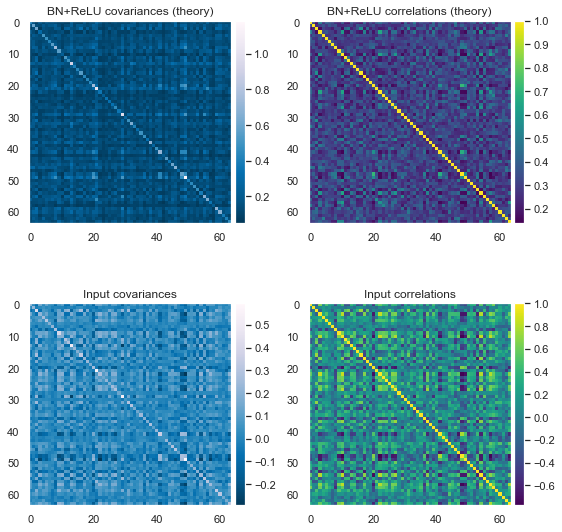

In [19]:
from utils import getCor, colorbar

plt.figure(figsize=(8, 8))

plt.subplot(221)
ax = plt.gca()
im_thcov = plt.imshow(ker, cmap='PuBu_r')
plt.title('BN+ReLU covariances (theory)')
plt.grid()
colorbar(im_thcov)

plt.subplot(222)
ax = plt.gca()
im_thcor = plt.imshow(getCor(ker), cmap='viridis')
plt.title('BN+ReLU correlations (theory)')
plt.grid()
colorbar(im_thcor)


plt.subplot(223)
ax = plt.gca()
im_input = plt.imshow(inker, cmap='PuBu_r')
plt.title('Input covariances')
plt.grid()
colorbar(im_input)

plt.subplot(224)
ax = plt.gca()
im_inputcor = plt.imshow(getCor(inker), cmap='viridis')
plt.title('Input correlations')
plt.grid()
colorbar(im_inputcor)

plt.tight_layout()

In [20]:
with open('BN.kernel', 'wb') as f:
    np.save(f, ker)

## Compute Simulations

In [21]:
from torch import nn
from torch.autograd import Variable
import pandas as pd

In [22]:
class MyNet(nn.Module):
    def __init__(self, nonlin, width=500, depth=2, inputdim=None):
        super(MyNet, self).__init__()
        self.nonlin = nonlin
        self.width = width
        self.depth = depth
        self.params = nn.ParameterList()
        self.BNs = nn.ModuleList()
        self.nonlins = nn.ModuleList()
        for i in range(depth):
            if i == 0:
                if inputdim is None:
                    inputdim = width
                w = Variable(torch.randn(width, inputdim) / np.sqrt(width), requires_grad=True)
            else:
                w = Variable(torch.randn(width, width) / np.sqrt(width), requires_grad=True)
            self.params.append(nn.Parameter(w))
            self.BNs.append(nn.BatchNorm1d(width, eps=0, momentum=None, affine=False, track_running_stats=False))
            self.nonlins.append(nonlin())
    def forward(self, x):
        for i in range(self.depth):
            w = self.params[i]
            h = torch.einsum('ij,kj->ki', w, x)
            x = self.nonlins[i](self.BNs[i](h))
        return x
        

We randomly initialize 100 BN+ReLU networks for each width among $[2^5, 2^6, \ldots, 2^{13}]$ and run them on the two batches defined above.
We calculate the empirical Gram matrix of the network outputs as well as its Frobenius distance to the infinite-width theoretical kernel.

In [23]:
widths = [2**i for i in range(5, 13)]
frobs = []
V11 = Sigma1s[-1]
V22 = Sigma2s[-1]
V12 = Xis[-1]
V11frob = np.sum(V11**2)
V22frob = np.sum(V22**2)
V12frob = np.sum(V12**2)
Vfrob = V11frob + V22frob + 2 * V12frob
batch1 = torch.from_numpy(myimages1.reshape(nsamples//2, -1))
batch2 = torch.from_numpy(myimages2.reshape(nsamples//2, -1))
for width in widths:
    for _ in range(100):
        mynet = MyNet(nn.ReLU,
                      width=width,
                      depth=depth, inputdim=3072)
        out = []
        simbatch1 = mynet(batch1)
        simbatch2 = mynet(batch2)
        simV11 = simbatch1 @ simbatch1.t() / simbatch1.shape[-1]
        simV22 = simbatch2 @ simbatch2.t() / simbatch2.shape[-1]
        simV12 = simbatch1 @ simbatch2.t() / simbatch1.shape[-1]
        diffV11 = simV11 - torch.from_numpy(V11).float()
        diffV22 = simV22 - torch.from_numpy(V22).float()
        diffV12 = simV12 - torch.from_numpy(V12).float()
        difffrob11 = torch.sum(diffV11**2).item()
        difffrob22 = torch.sum(diffV22**2).item()
        difffrob12 = torch.sum(diffV12**2).item()
        frobs.append(
        {
            'relfrob11': difffrob11 / V11frob,
            'relfrob22': difffrob22 / V22frob,
            'relfrob12': difffrob12 / V12frob,
            'relfrob': (difffrob11 + difffrob22 + 2 * difffrob12) / Vfrob,
            'width': width
        })

We store the results in a dataframe `frob_df`.

In [24]:
frob_df = pd.DataFrame(frobs)

In [25]:
frob_df.to_pickle('BN.df')

## Compare Theory with Simulations

The deviation from infinite-width theory drops with width, as expected.

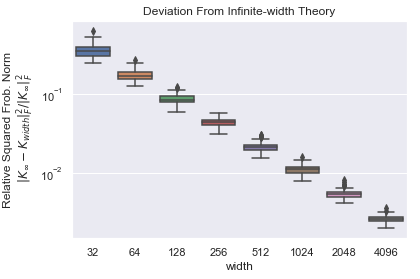

In [26]:
sns.boxplot(x='width', y='relfrob12', data=frob_df)
plt.semilogy()
plt.title('Deviation From Infinite-width Theory')
_ = plt.ylabel(u'Relative Squared Frob. Norm\n $\|K_{\infty} - K_{width}\|_F^2/\|K_{\infty}\|_F^2$')

The deviation from theory in *squared* Frobenius norm scales like $\frac{1}{width}$ (so, in Frobenius norm, the deviation scales like $width^{-1/2}$).

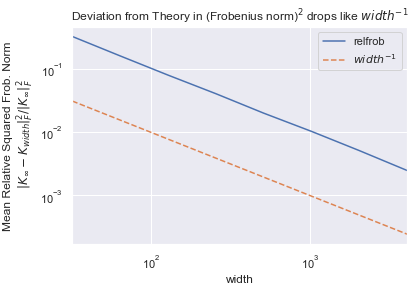

In [27]:
frob_df.groupby('width', as_index=False).mean().plot.line(x='width', y='relfrob')
plt.plot(widths, np.array(widths, dtype='float')**-1, '--', label=u'${width}^{-1}$')
plt.ylabel(u'Mean Relative Squared Frob. Norm\n $\|K_{\infty} - K_{width}\|_F^2/\|K_{\infty}\|_F^2$')
plt.loglog()
plt.legend()
_ = plt.title(u'Deviation from Theory in (Frobenius norm)$^2$ drops like $width^{-1}$')